In [1]:
import torch
from quant_gans import Generator, Discriminator, TemporalBlock, Trim1d, Loader32, rolling_window
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
from tqdm import tqdm

from gaussianize import *

In [2]:
data_path = 'AAPL.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def dateparse(d):
    return pd.Timestamp(d)

# Preprossesing
data = pd.read_csv(data_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['Close']

returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

num_epochs = 100
nz = 3
batch_size = 80
seq_len = 80
clip= 0.01
lr = 0.0002
generator_path = f'./trained/'
file_name = 'AAPL_daily'

generator = Generator().to(device)

train = True

if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(log_returns_preprocessed, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval() 

  0%|          | 0/100 [00:00<?, ?it/s]/home/mid/py_projects/deep_generative/final_project/quant_gans.py:126: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402312629/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  return self.to_prob(x.T).squeeze()
Discriminator Loss: -0.00000364 Generator Loss: -0.50247234: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


In [7]:
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

#filtering
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

79

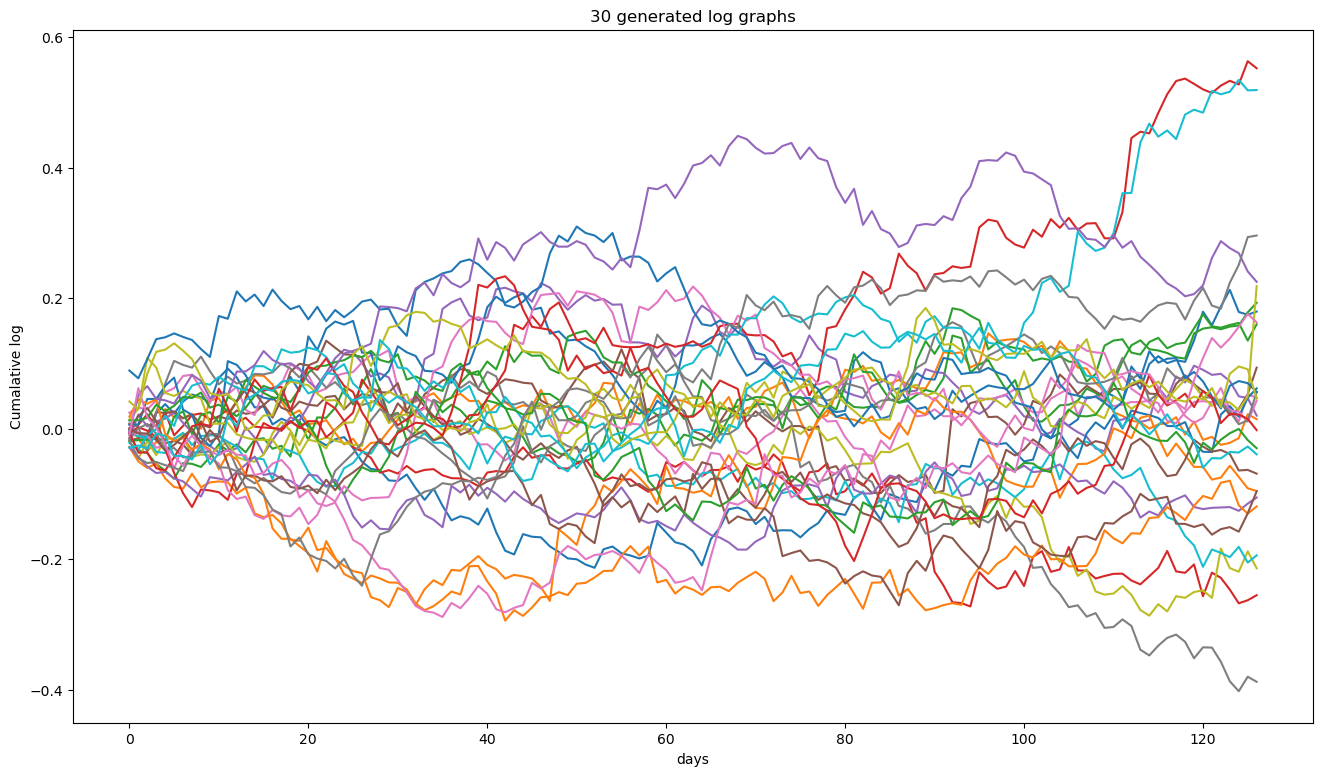

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T)
ax.set_title('30 generated log graphs'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log');

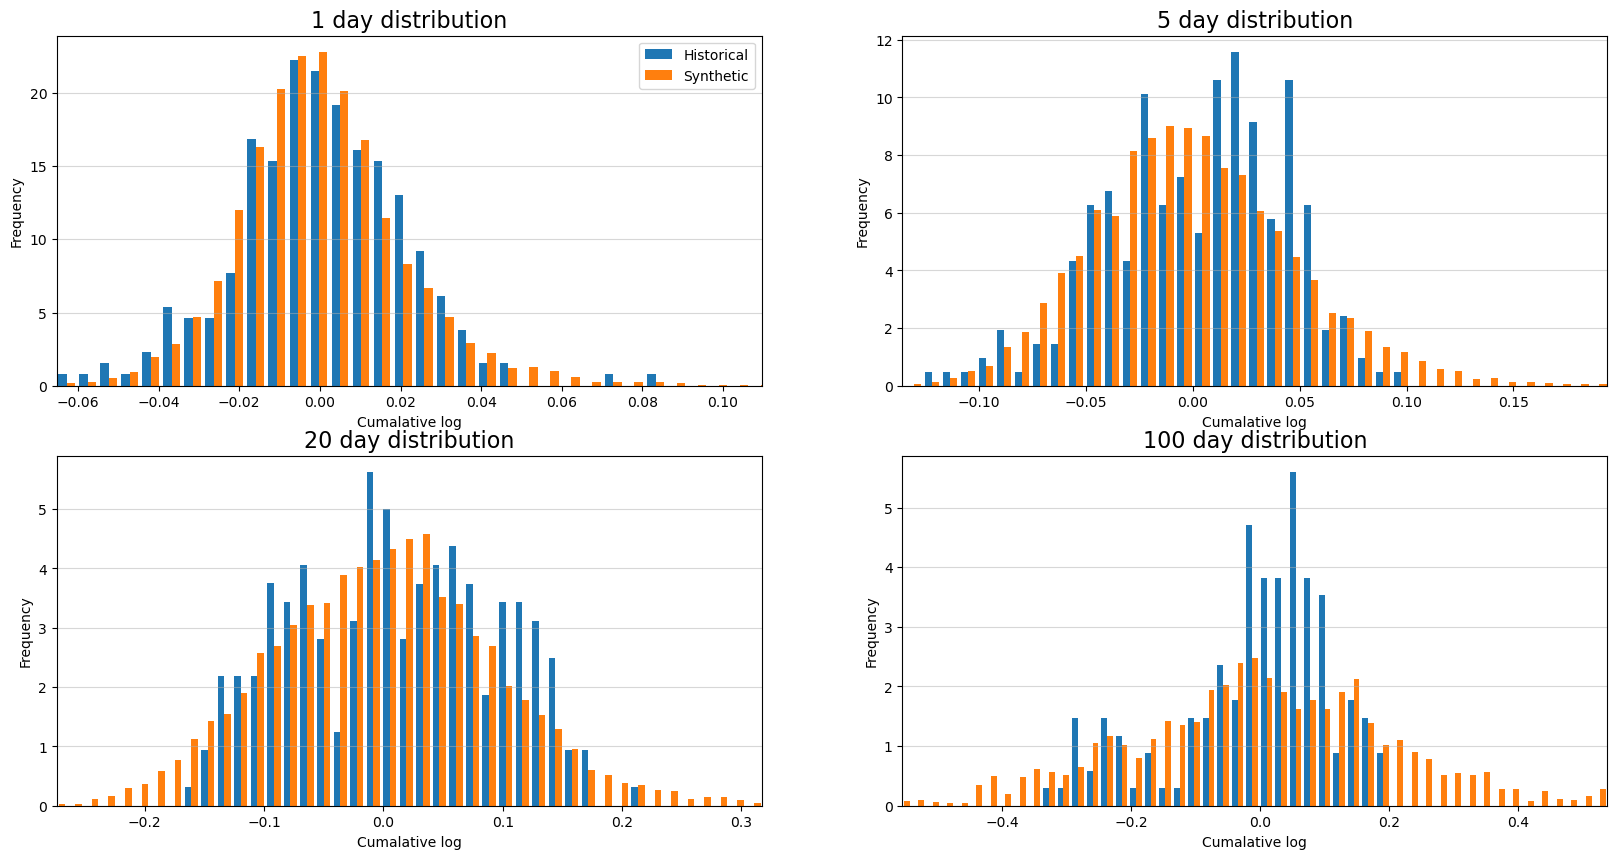

In [11]:
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical', 'Synthetic'])
plt.show()